# MDN Hands On Tutorial
This notebook demonstrates the construction of a simple MDN, and compares it to a regular neural network.

Read about MDNs on the [original paper](https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) by C. Bishop.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
from sklearn.utils import shuffle

The network we'll construct will try to learn the following relation between $x$ and $f(x)$: 

$$f(x) = x^2-6x+9$$


Note that this simply $y = x^2$ shifted three steps to the left (global minimum is at $x=3$).

In [2]:
def f(x):
    return x**2-6*x+9 

In order to make the data a little bit more relaistic, we'll add a normally-distributed noise, which will be location-dependent - the larger $x$ is, the larger the noisier the data will be. So, our data generator will obey the following relation:

$$g(x) = f(x) + \epsilon(x) $$ 

$$ \text{where}: \epsilon(x) = N(0,\sigma_0 x)$$

Where $N(\mu,\sigma)$ is the normal distribution with mean $\mu$ and STD of $\sigma$.

The `data_generator` below function creates $n$ nosiy data samples for a given `x`, where $n$ is defined by `samples`. Notice that technically, `data_generator` yields $g(x) = N(f(x),\sigma_0 x)$, as mathematically that's the same thing. 

In [3]:
def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

We'll now generate our dataset for $1<x<5$.

The purple line in the plot presents the "clean" function $f(x)$ for this range.

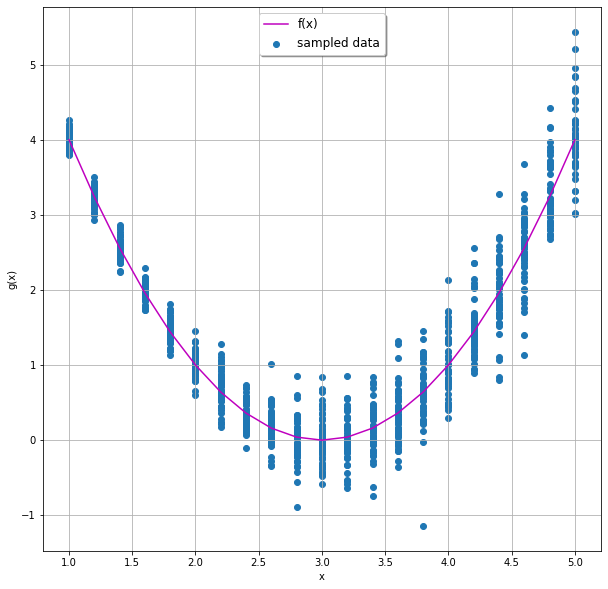

In [4]:
sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1,5.1,0.2)

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr,label='sampled data')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Regular neural network
We'll now train a neural network which will receive $x$ as input and our noisy $g(x)$ but will have to learn the relation $x \rightarrow f(x)$.

The network is constructed of two hidden layers, each with 12 nodes and the $\tanh(x)$ activation function (note we don't use any activation on the last output layer).

We set the learning rate $\alpha=0.0003$, 50 examples per mini-batch and a total of 500 epoches.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________
Train on 1050 samples
Epoch 1/500
1050/1050 [==============================] - 0s 426us/sample - loss: 3.1484
Epoch 2/500
1050/10

1050/1050 [==============================] - 0s 35us/sample - loss: 0.6660
Epoch 83/500
1050/1050 [==============================] - 0s 32us/sample - loss: 0.6302
Epoch 84/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.5992
Epoch 85/500
1050/1050 [==============================] - 0s 31us/sample - loss: 0.5668
Epoch 86/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.5375
Epoch 87/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.5108
Epoch 88/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.4811
Epoch 89/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.4655
Epoch 90/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.4372
Epoch 91/500
1050/1050 [==============================] - 0s 32us/sample - loss: 0.4134
Epoch 92/500
1050/1050 [==============================] - 0s 34us/sample - loss: 0.3983
Epoch 93/500
1050/1050 [=====================

1050/1050 [==============================] - 0s 35us/sample - loss: 0.1542
Epoch 175/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1536
Epoch 176/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1527
Epoch 177/500
1050/1050 [==============================] - 0s 42us/sample - loss: 0.1505
Epoch 178/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1513
Epoch 179/500
1050/1050 [==============================] - ETA: 0s - loss: 0.312 - 0s 36us/sample - loss: 0.1501
Epoch 180/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1488
Epoch 181/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1468
Epoch 182/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1473
Epoch 183/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.1467
Epoch 184/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1455
Epoch 185/5

Epoch 266/500
1050/1050 [==============================] - 0s 33us/sample - loss: 0.1225
Epoch 267/500
1050/1050 [==============================] - 0s 33us/sample - loss: 0.1237
Epoch 268/500
1050/1050 [==============================] - 0s 33us/sample - loss: 0.1220
Epoch 269/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1216
Epoch 270/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1214
Epoch 271/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.1237
Epoch 272/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.1221
Epoch 273/500
1050/1050 [==============================] - 0s 33us/sample - loss: 0.1237
Epoch 274/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1215
Epoch 275/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1208
Epoch 276/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1209
Epoch 277/500
1050/10

1050/1050 [==============================] - 0s 42us/sample - loss: 0.1133
Epoch 359/500
1050/1050 [==============================] - 0s 32us/sample - loss: 0.1169
Epoch 360/500
1050/1050 [==============================] - 0s 33us/sample - loss: 0.1166
Epoch 361/500
1050/1050 [==============================] - 0s 34us/sample - loss: 0.1209
Epoch 362/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1142
Epoch 363/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1152
Epoch 364/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1126
Epoch 365/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.1153
Epoch 366/500
1050/1050 [==============================] - 0s 34us/sample - loss: 0.1182
Epoch 367/500
1050/1050 [==============================] - 0s 34us/sample - loss: 0.1150
Epoch 368/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1125
Epoch 369/500
1050/1050 [==========

1050/1050 [==============================] - 0s 35us/sample - loss: 0.1101
Epoch 451/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.1118
Epoch 452/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1109
Epoch 453/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.1104
Epoch 454/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1131
Epoch 455/500
1050/1050 [==============================] - 0s 33us/sample - loss: 0.1143
Epoch 456/500
1050/1050 [==============================] - 0s 34us/sample - loss: 0.1122
Epoch 457/500
1050/1050 [==============================] - 0s 34us/sample - loss: 0.1093
Epoch 458/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1090
Epoch 459/500
1050/1050 [==============================] - 0s 44us/sample - loss: 0.1093
Epoch 460/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.1105
Epoch 461/500
1050/1050 [==========

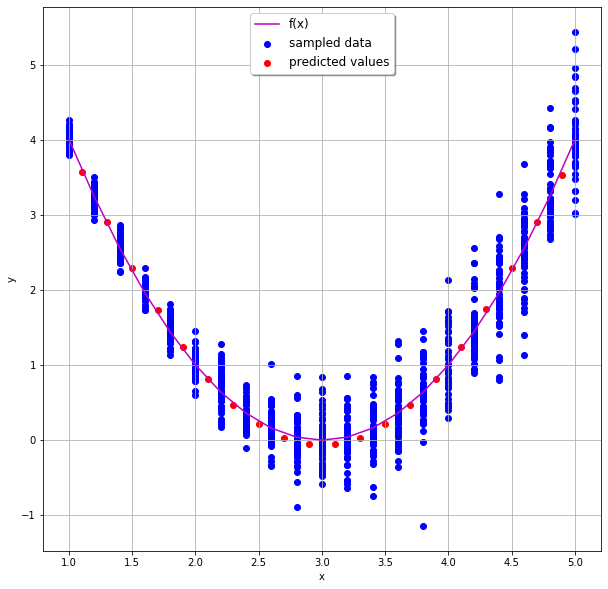

In [5]:
epochs = 500
batch_size = 50
learning_rate = 0.0003

l_inp = tf.keras.layers.Input(1)
l = l_inp
for _ in range(3):
    l = tf.keras.layers.Dense(12, activation="tanh")(l)
l_out = tf.keras.layers.Dense(1)(l)

def loss(y_true, y_pred):
    return tf.reduce_mean(tf.losses.MSE(y_true, y_pred))
    
s = tf.keras.models.Model(inputs=[l_inp], outputs=[l_out])
s.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss = loss)
s.summary()

s.fit(
    x=x_arr,
    y=y_arr,
    batch_size=batch_size,
    epochs=epochs
)

y_pred = s.predict(np.expand_dims(x_test,axis=1))

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b',label='sampled data')
ax.scatter(x_test,y_pred,c='r',label='predicted values')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

It seems to be doing quite good in predicting $f(x)$, but we can clearly see that the network learnt nothing about the size of the noise. 

## Mixture density network (MDN)
Let's try an MDN now. We'll use the same network as in the previous section, with one important change:
the output layer now has two nodes (which are constructed as two layers of 1 node for technical simplicity), which we named `mu` and `sigma`

Note the new cost function: we create a normal distribution out of the predicted `mu` and `sigma`, and then minimize the negative log-likelihood of this distribution yielding the traget value `y`. Mathematically, our cost function is the negative logarithm of the normal distribution's probability density function (PDF):

$$Cost = -\log (PDF) = -\log\left(\frac{1}{\sqrt{2\pi}\sigma}\cdot\exp{\left[-\frac{(y-\mu)^{2}}{2\sigma^{2}}\right]}\right)$$

In [6]:
def mdn_cost(y_true, y_pred):
    dist = tfp.distributions.Normal(loc=tf.expand_dims(y_pred[:,0], 1), scale=tf.expand_dims(y_pred[:,1], 1))
    return tf.reduce_mean(-dist.log_prob(y_true))

We'll use `elu + 1` as the activation function for `sigma`, as it must always be non-negative. The Exponential Linear Unit (ELU) is defined as:

$$ ELU(x) = \begin{cases} x & x\ge0 \\ \exp{(x)}-1 & x < 0 \end{cases} $$

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 12)           24          input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 12)           156         dense_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 12)           156         dense_5[0][0]                    
____________________________________________________________________________________________

1050/1050 [==============================] - 0s 39us/sample - loss: 0.4865
Epoch 72/500
1050/1050 [==============================] - 0s 42us/sample - loss: 0.4896
Epoch 73/500
1050/1050 [==============================] - 0s 40us/sample - loss: 0.4650
Epoch 74/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.4398
Epoch 75/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.4290
Epoch 76/500
1050/1050 [==============================] - 0s 44us/sample - loss: 0.4389
Epoch 77/500
1050/1050 [==============================] - 0s 29us/sample - loss: 0.4230
Epoch 78/500
1050/1050 [==============================] - 0s 41us/sample - loss: 0.4109
Epoch 79/500
1050/1050 [==============================] - 0s 40us/sample - loss: 0.4026
Epoch 80/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.4000
Epoch 81/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.3945
Epoch 82/500
1050/1050 [=====================

1050/1050 [==============================] - 0s 36us/sample - loss: 0.2720
Epoch 164/500
1050/1050 [==============================] - 0s 42us/sample - loss: 0.2806
Epoch 165/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.2758
Epoch 166/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.2761
Epoch 167/500
1050/1050 [==============================] - 0s 41us/sample - loss: 0.2730
Epoch 168/500
1050/1050 [==============================] - 0s 28us/sample - loss: 0.2684
Epoch 169/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.2825
Epoch 170/500
1050/1050 [==============================] - 0s 42us/sample - loss: 0.2670
Epoch 171/500
1050/1050 [==============================] - 0s 27us/sample - loss: 0.2652
Epoch 172/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.2681
Epoch 173/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.2649
Epoch 174/500
1050/1050 [==========

1050/1050 [==============================] - 0s 39us/sample - loss: 0.2002
Epoch 256/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.2048
Epoch 257/500
1050/1050 [==============================] - 0s 41us/sample - loss: 0.2008
Epoch 258/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.2009
Epoch 259/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1977
Epoch 260/500
1050/1050 [==============================] - 0s 34us/sample - loss: 0.1930
Epoch 261/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1965
Epoch 262/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.2072
Epoch 263/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.2040
Epoch 264/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1988
Epoch 265/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.1935
Epoch 266/500
1050/1050 [==========

1050/1050 [==============================] - 0s 41us/sample - loss: 0.1454
Epoch 348/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1493
Epoch 349/500
1050/1050 [==============================] - 0s 43us/sample - loss: 0.1404
Epoch 350/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1410
Epoch 351/500
1050/1050 [==============================] - 0s 33us/sample - loss: 0.1495
Epoch 352/500
1050/1050 [==============================] - 0s 51us/sample - loss: 0.1441
Epoch 353/500
1050/1050 [==============================] - 0s 25us/sample - loss: 0.1410
Epoch 354/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1490
Epoch 355/500
1050/1050 [==============================] - 0s 38us/sample - loss: 0.1448
Epoch 356/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1421
Epoch 357/500
1050/1050 [==============================] - 0s 37us/sample - loss: 0.1433
Epoch 358/500
1050/1050 [==========

1050/1050 [==============================] - 0s 40us/sample - loss: 0.1227
Epoch 440/500
1050/1050 [==============================] - 0s 41us/sample - loss: 0.1196
Epoch 441/500
1050/1050 [==============================] - 0s 40us/sample - loss: 0.1213
Epoch 442/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1353
Epoch 443/500
1050/1050 [==============================] - 0s 44us/sample - loss: 0.1227
Epoch 444/500
1050/1050 [==============================] - 0s 29us/sample - loss: 0.1207
Epoch 445/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1223
Epoch 446/500
1050/1050 [==============================] - 0s 41us/sample - loss: 0.1226
Epoch 447/500
1050/1050 [==============================] - 0s 39us/sample - loss: 0.1213
Epoch 448/500
1050/1050 [==============================] - 0s 36us/sample - loss: 0.1197
Epoch 449/500
1050/1050 [==============================] - 0s 35us/sample - loss: 0.1217
Epoch 450/500
1050/1050 [==========

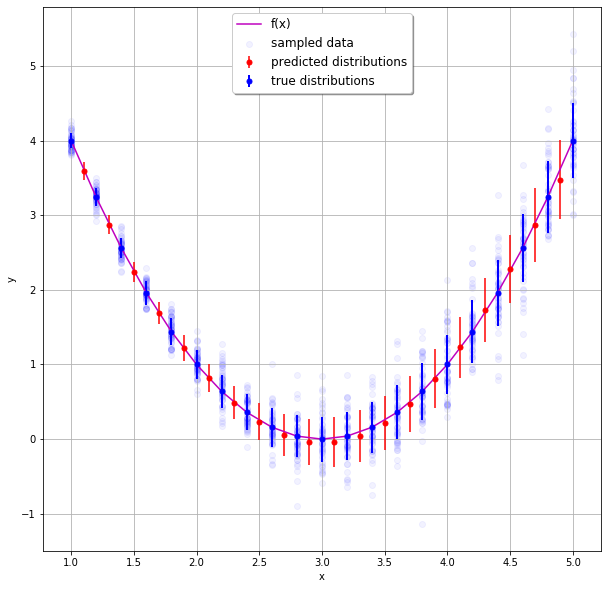

In [7]:
l_inp = tf.keras.layers.Input(1)
l = l_inp
for _ in range(3):
    l = tf.keras.layers.Dense(12, activation="tanh")(l)
l_out_mu = tf.keras.layers.Dense(1)(l)
l_out_sigma = tf.keras.layers.Dense(1, activation=lambda x: tf.nn.elu(x) + 1)(l)
l_out = tf.keras.layers.concatenate(inputs=[l_out_mu, l_out_sigma], axis=1)

s = tf.keras.models.Model(inputs=[l_inp], outputs=[l_out])
s.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss=mdn_cost)
s.summary()

s.fit(
    x=x_arr,
    y=y_arr,
    batch_size=batch_size,
    epochs=epochs
)

y_pred = s.predict(np.expand_dims(x_test,axis=1))
mu_pred = y_pred[...,0]
sigma_pred = y_pred[...,1]

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

The plot above shows the results learnt by the network. In red are the networks predictions for $\mu$ and $\sigma$, and in blue are the actual $\mu$ and $\sigma$ used for the training set. The actual data can be seen faded in the background. We can clearly see the network has learnt not just $x \rightarrow f(x)$, but also the noise creating $x \rightarrow g(x)$.